# Assignment Week 1 - Group 5

### Noelani Roy, Yihong Qiu, Cosimo Cambi, Craig Perkins

In [2]:
import pandas as pd
import numpy as np

In [8]:
filename = "../fraudTrain.csv"
filename2 = "../fraudTest.csv"

df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

fraud_df = pd.concat([df, df2])

# print(fraud_df)

In [4]:
fraud_df.shape

(1852394, 23)

In [9]:
from datetime import date
import geopy.distance

from math import sin, cos, sqrt, atan2, radians, log

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)


# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

fraud_df['log_amt'] = [log(n) for n in fraud_df['amt']]
    

# Drop the columns used to derive new features
fraud_df.drop([
    'Unnamed: 0',
    'trans_num',
    'unix_time',
    'first',
    'last',
    'street',
    'city',
    'state',
    'zip',
    'dob',
    'trans_date_trans_time',
    'lat',
    'long',
    'merch_lat',
    'merch_long'
], axis=1, errors='ignore', inplace=True)


cols = list(fraud_df.columns)
cols.insert(0, cols.pop(cols.index("txn_datetime")))
cols.append(cols.pop(cols.index('is_fraud')))
fraud_df = fraud_df[cols]

In [11]:
fraud_df.to_csv('fraudFeatures.csv', index=False)

In [12]:
filename1 = "fraudFeatures.csv"
fraud_df = pd.read_csv(filename1)

In [4]:
cat_col = ['category','gender']
num_col = ['age','distance','year','month','day','hour','city_pop']

In [20]:
# This one hot encodes the categorical columns and create a new variable to hold the nex column headers

cat_col_onehotencode = []

if len(cat_col) > 0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col])
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

In [44]:
# fraud_df['distance_round'] = [5 * round(d/5) for d in fraud_df['distance']]

# cols = list(fraud_df.columns)
# cols.append(cols.pop(cols.index('is_fraud')))
# fraud_df = fraud_df[cols]

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(fraud_df['cc_num'])
fraud_df['cc_num'] = le.transform(fraud_df['cc_num'])

In [22]:
fraud_df.drop([
    'txn_datetime',
    'merchant',
    'category',
    'gender',
    'job'
], axis=1, errors='ignore', inplace=True)

In [26]:
# fraud_df.to_csv('fraudFeaturesHotEncoder.csv', index=False)

filename2 = "fraudFeaturesHotEncoder.csv"
fraud_df = pd.read_csv(filename2)

In [25]:
import qgrid

qgrid.show_grid(fraud_df.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [45]:
feature_cols = [col for col in fraud_df.columns if col not in ["is_fraud"]]

target = "is_fraud"

X = fraud_df[feature_cols]
y = fraud_df[target]

In [35]:
fraud_df["is_fraud"].value_counts()

0    1842743
1       9651
Name: is_fraud, dtype: int64

In [46]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

X_res, y_res = nm.fit_sample(X, y)

In [34]:
print(X_res.shape)
print(y_res.shape)

(19302, 26)
(19302,)


In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

vif_test = add_constant(fraud_df[['amt', 'log_amt', 'city_pop', 'age', 'distance', 'distance_round']].head(1000))
vif_series = pd.Series([variance_inflation_factor(vif_test.values, i) 
               for i in range(vif_test.shape[1])], 
              index=vif_test.columns)

print(vif_series)

const              32.117498
amt                 1.699391
log_amt             1.768235
city_pop            1.016398
age                 1.099645
distance          404.045055
distance_round    404.126783
dtype: float64


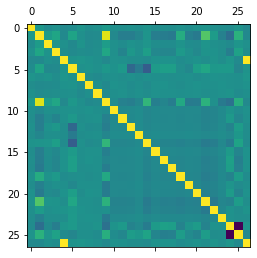

In [69]:
import matplotlib.pyplot as plt

plt.matshow(X_res.corr())
plt.show()

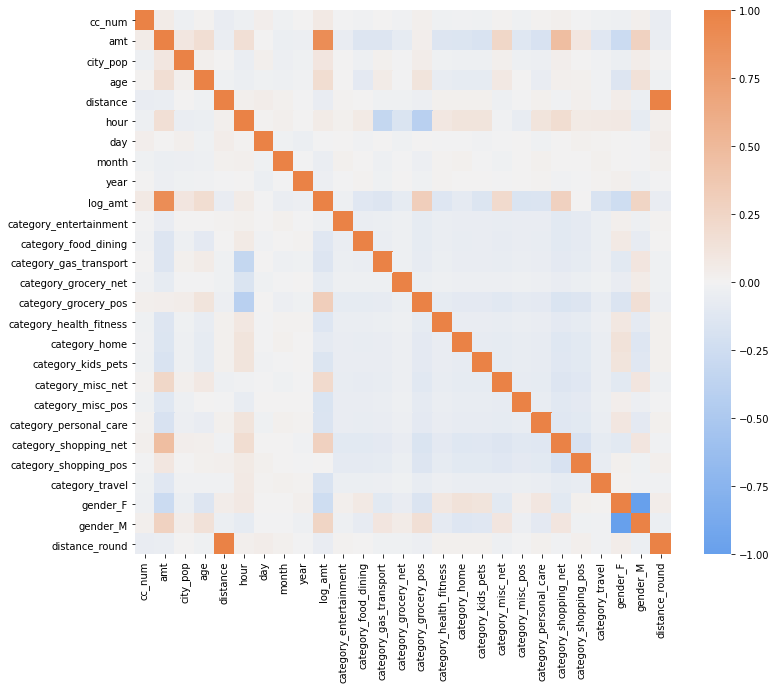

In [70]:
import seaborn as sns

plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(250, 30, s=80, l=65, as_cmap=True)
sns.heatmap(X_res.corr(), cmap=cmap)
plt.show()

In [39]:
import qgrid

qgrid.show_grid(X_res.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [38]:
import qgrid

qgrid.show_grid(y_res.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

[[1.56213637e-02 5.10823872e-03 3.82716049e-01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.27705376e-02 6.07566647e-04 2.83950617e-01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.53231906e-02 4.95411083e-05 2.09876543e-01 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 ...
 [7.55192576e-01 4.96752821e-03 5.67901235e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [2.09644810e-01 4.96752821e-03 5.67901235e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]
 [5.56623807e-01 4.96752821e-03 5.67901235e-01 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


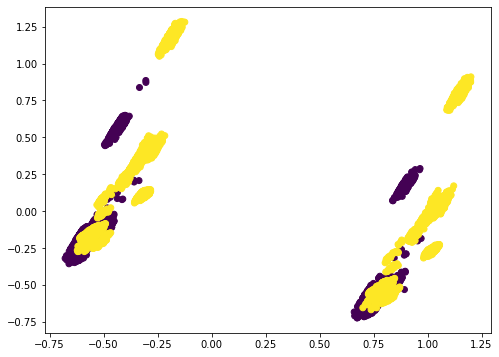

In [96]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pca = PCA(n_components=2)

pca_test = X_res.drop(['cc_num', 'distance_round'], axis=1, errors='ignore')

date_cols = ['hour', 'day', 'month', 'year']
other_cols = [col for col in pca_test.columns if col not in date_cols]

pca_test = pca_test[other_cols]

# print(pca_test)

scaler = MinMaxScaler()
scaler.fit(pca_test)

scaled_data = scaler.transform(pca_test)

# print(scaled_data)

pca.fit(scaled_data)
pca_transform = pca.transform(scaled_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_transform[:,0], pca_transform[:,1], c=y_res)

In [50]:
txn_amounts_by_consumer_by_distance = fraud_df.groupby(['cc_num', 'distance_round'])['amt'].agg('sum').sort_index().reset_index()
txn_amounts_by_consumer_by_distance.columns = ['cc_num', 'distance_round','amt']

txn_amounts_by_consumer_by_distance_balanced = X_res.groupby(['cc_num', 'distance_round'])['amt'].agg('sum').sort_index().reset_index()
txn_amounts_by_consumer_by_distance_balanced.columns = ['cc_num', 'distance_round','amt']


# qgrid.show_grid(txn_amounts_by_consumer_by_distance.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})



Text(0, 0.5, 'amt')

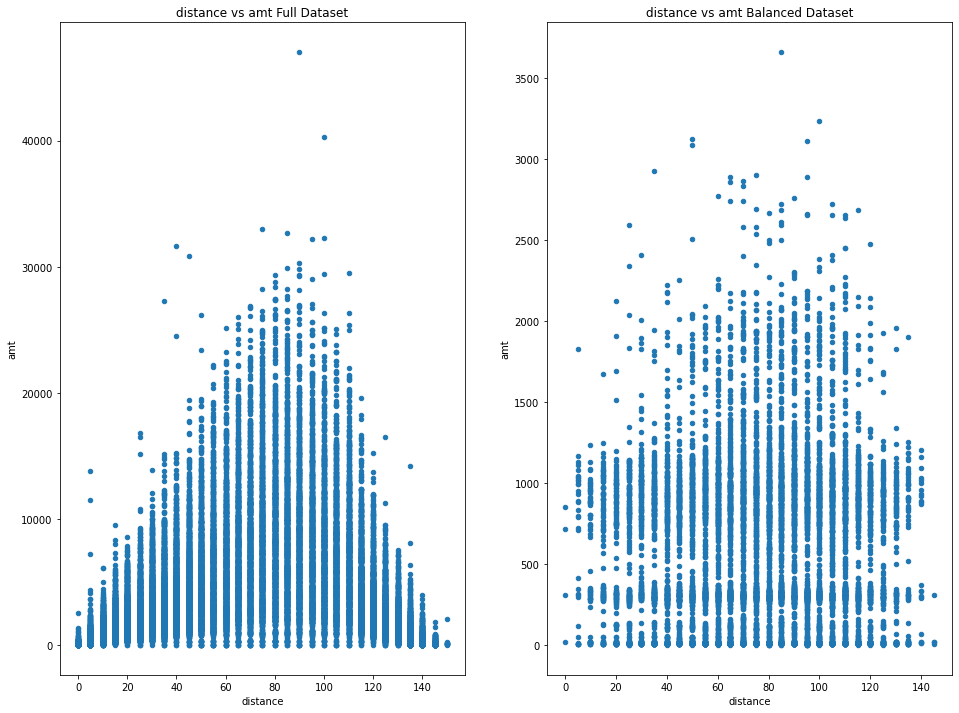

In [53]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)

ax1 = txn_amounts_by_consumer_by_distance.plot(kind='scatter', x='distance_round', y='amt', figsize=(16,12), ax=axes[0], title='distance vs amt Full Dataset')
ax1.set_xlabel('distance')
ax1.set_ylabel('amt')

ax2 = txn_amounts_by_consumer_by_distance_balanced.plot(kind='scatter', x='distance_round', y='amt', figsize=(16,12), ax=axes[1], title='distance vs amt Balanced Dataset')
ax2.set_xlabel('distance')
ax2.set_ylabel('amt')


In [54]:
txn_amounts_by_consumer_by_hour = fraud_df.groupby(['cc_num', 'hour'])['amt'].agg('sum').sort_index().reset_index()
txn_amounts_by_consumer_by_hour.columns = ['cc_num', 'hour','amt']

txn_amounts_by_consumer_by_hour_balanced = X_res.groupby(['cc_num', 'hour'])['amt'].agg('sum').sort_index().reset_index()
txn_amounts_by_consumer_by_hour_balanced.columns = ['cc_num', 'hour','amt']

# qgrid.show_grid(txn_amounts_by_consumer_by_hour.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})



Text(0, 0.5, 'amt')

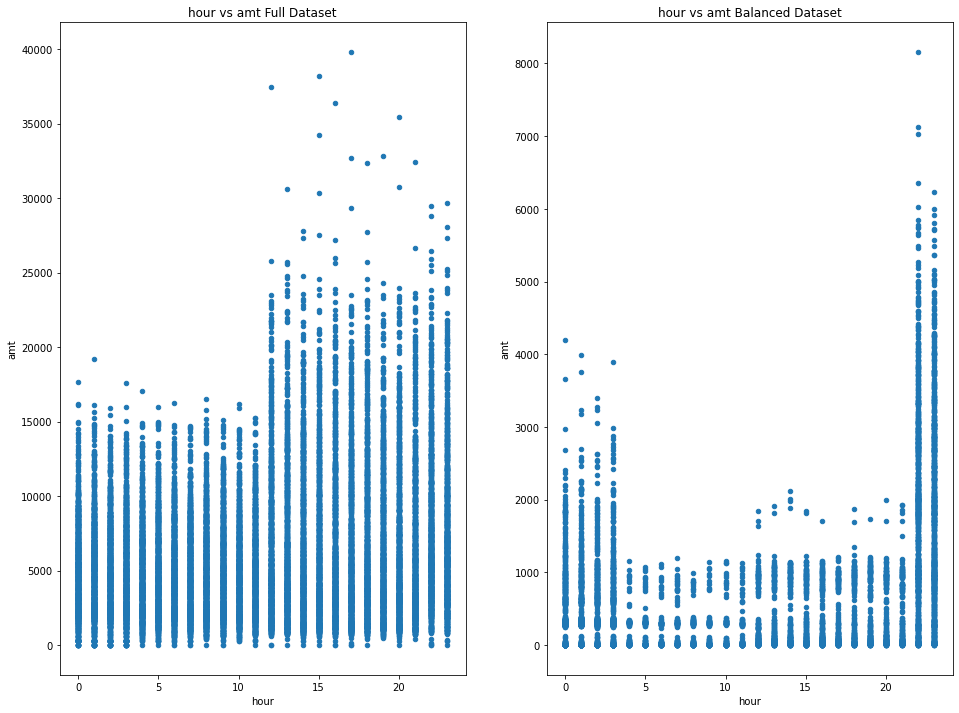

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)

ax1 = txn_amounts_by_consumer_by_hour.plot(kind='scatter', x='hour', y='amt', figsize=(16,12), ax=axes[0], title='hour vs amt Full Dataset')
ax1.set_xlabel('hour')
ax1.set_ylabel('amt')

ax2 = txn_amounts_by_consumer_by_hour_balanced.plot(kind='scatter', x='hour', y='amt', figsize=(16,12), ax=axes[1], title='hour vs amt Balanced Dataset')
ax2.set_xlabel('hour')
ax2.set_ylabel('amt')


In [58]:
txn_counts_by_city_pop = fraud_df['city_pop'].value_counts().sort_index().reset_index()
txn_counts_by_city_pop.columns = ['city_pop','count']

txn_counts_by_city_pop_balanced = X_res['city_pop'].value_counts().sort_index().reset_index()
txn_counts_by_city_pop_balanced.columns = ['city_pop','count']

# qgrid.show_grid(txn_counts_by_city_pop.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

Text(0, 0.5, 'count')

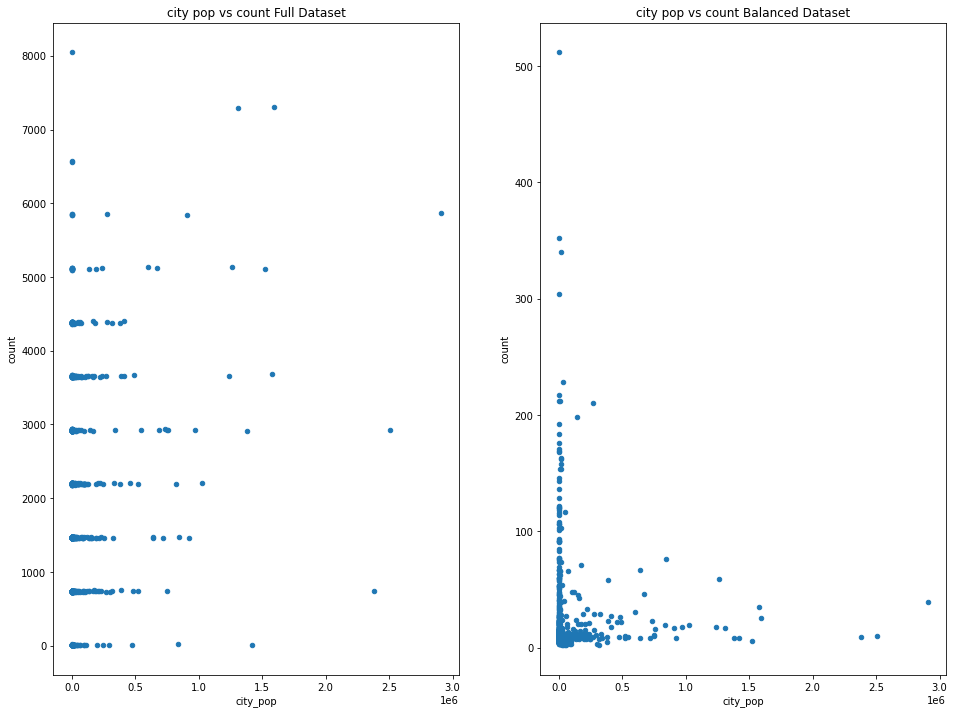

In [59]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)

ax1 = txn_counts_by_city_pop.plot(kind='scatter', x='city_pop', y='count', figsize=(16,12), ax=axes[0], title='city pop vs count Full Dataset')
ax1.set_xlabel('city_pop')
ax1.set_ylabel('count')

ax2 = txn_counts_by_city_pop_balanced.plot(kind='scatter', x='city_pop', y='count', figsize=(16,12), ax=axes[1], title='city pop vs count Balanced Dataset')
ax2.set_xlabel('city_pop')
ax2.set_ylabel('count')


In [61]:
txn_amounts_by_city_pop = fraud_df.groupby(['city_pop'])['amt'].agg('sum').sort_index().reset_index()
txn_amounts_by_city_pop.columns = ['city_pop','amt']

txn_amounts_by_city_pop_balanced = X_res.groupby(['city_pop'])['amt'].agg('sum').sort_index().reset_index()
txn_amounts_by_city_pop_balanced.columns = ['city_pop','amt']

# qgrid.show_grid(txn_amounts_by_city_pop.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

Text(0, 0.5, 'amt')

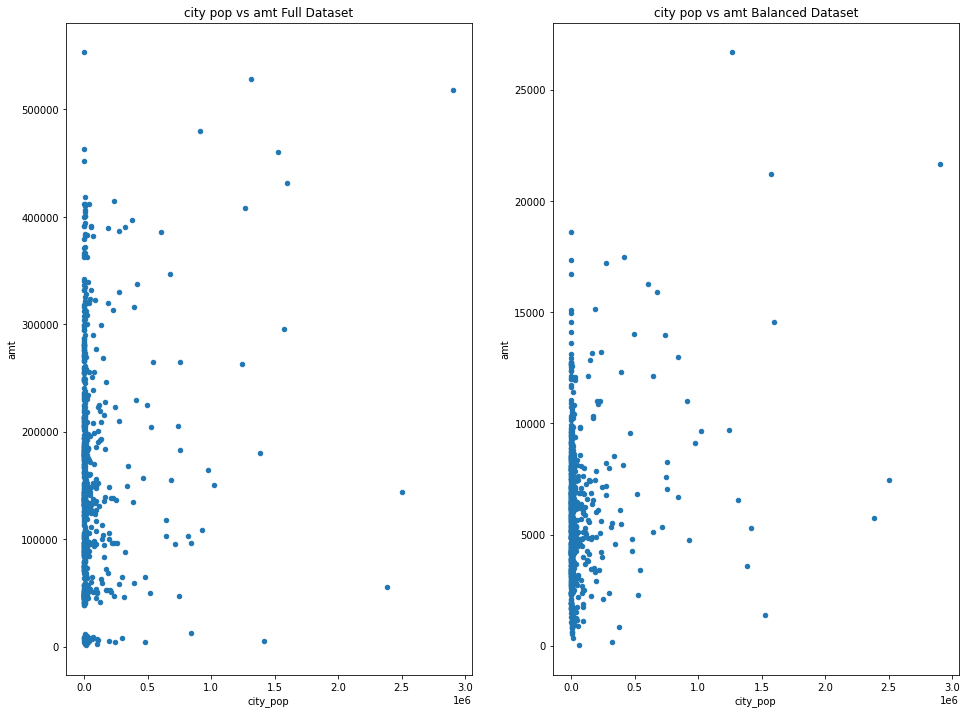

In [62]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)

ax1 = txn_amounts_by_city_pop.plot(kind='scatter', x='city_pop', y='amt', figsize=(16,12), ax=axes[0], title='city pop vs amt Full Dataset')
ax1.set_xlabel('city_pop')
ax1.set_ylabel('amt')

ax2 = txn_amounts_by_city_pop_balanced.plot(kind='scatter', x='city_pop', y='amt', figsize=(16,12), ax=axes[1], title='city pop vs amt Balanced Dataset')
ax2.set_xlabel('city_pop')
ax2.set_ylabel('amt')


In [64]:
txn_counts_by_age = fraud_df['age'].value_counts().sort_index().reset_index()
txn_counts_by_age.columns = ['age','count']

txn_counts_by_age_balanced = X_res['age'].value_counts().sort_index().reset_index()
txn_counts_by_age_balanced.columns = ['age','count']

# qgrid.show_grid(txn_counts_by_age.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

Text(0, 0.5, 'count')

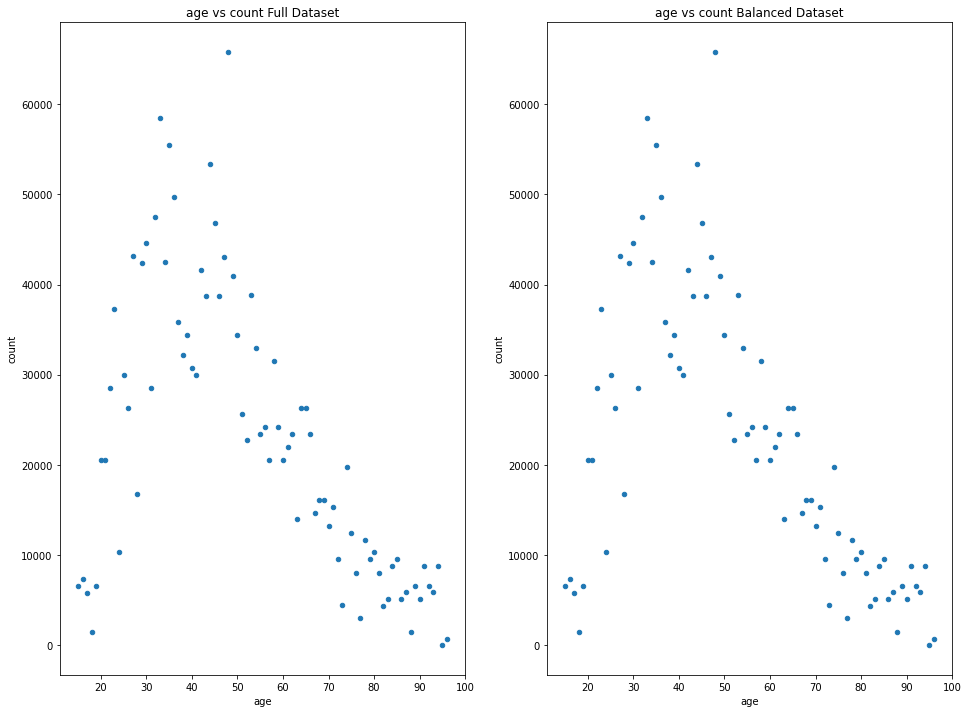

In [65]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)

ax1 = txn_counts_by_age.plot(kind='scatter', x='age', y='count', figsize=(16,12), ax=axes[0], title='age vs count Full Dataset')
ax1.set_xlabel('age')
ax1.set_ylabel('count')

ax2 = txn_counts_by_age.plot(kind='scatter', x='age', y='count', figsize=(16,12), ax=axes[1], title='age vs count Balanced Dataset')
ax2.set_xlabel('age')
ax2.set_ylabel('count')


In [67]:
txn_amounts_by_age = fraud_df.groupby(['age'])['amt'].agg('sum').sort_index().reset_index()
txn_amounts_by_age.columns = ['age','amt']

txn_amounts_by_age_balanced = X_res.groupby(['age'])['amt'].agg('sum').sort_index().reset_index()
txn_amounts_by_age_balanced.columns = ['age','amt']

# qgrid.show_grid(txn_amounts_by_age.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})

Text(0, 0.5, 'amt')

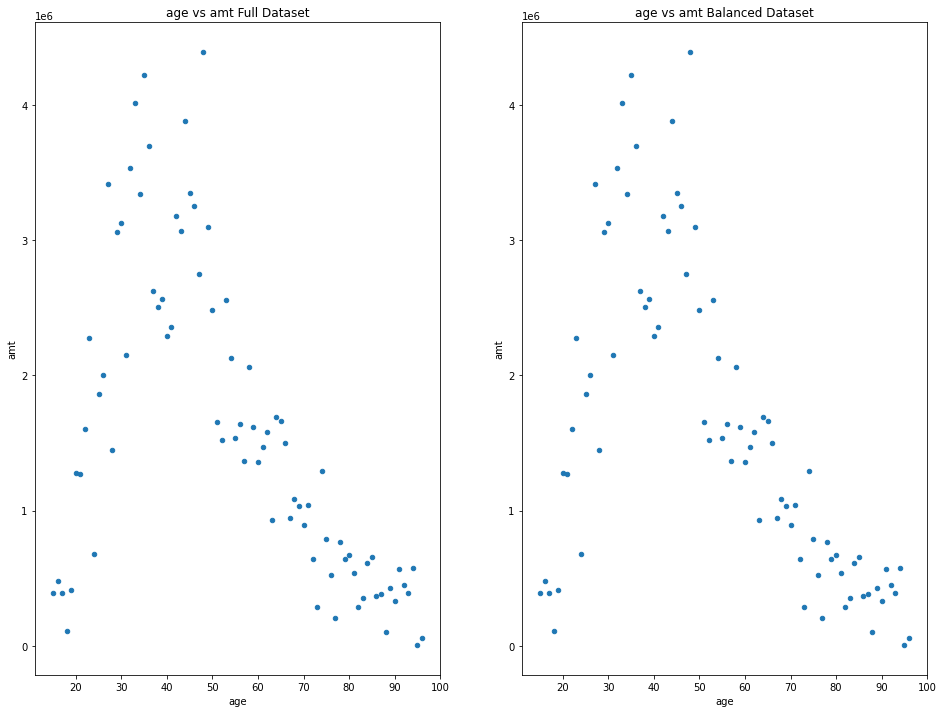

In [68]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)

ax1 = txn_amounts_by_age.plot(kind='scatter', x='age', y='amt', figsize=(16,12), ax=axes[0], title='age vs amt Full Dataset')
ax1.set_xlabel('age')
ax1.set_ylabel('amt')

ax2 = txn_amounts_by_age.plot(kind='scatter', x='age', y='amt', figsize=(16,12), ax=axes[1], title='age vs amt Balanced Dataset')
ax2.set_xlabel('age')
ax2.set_ylabel('amt')


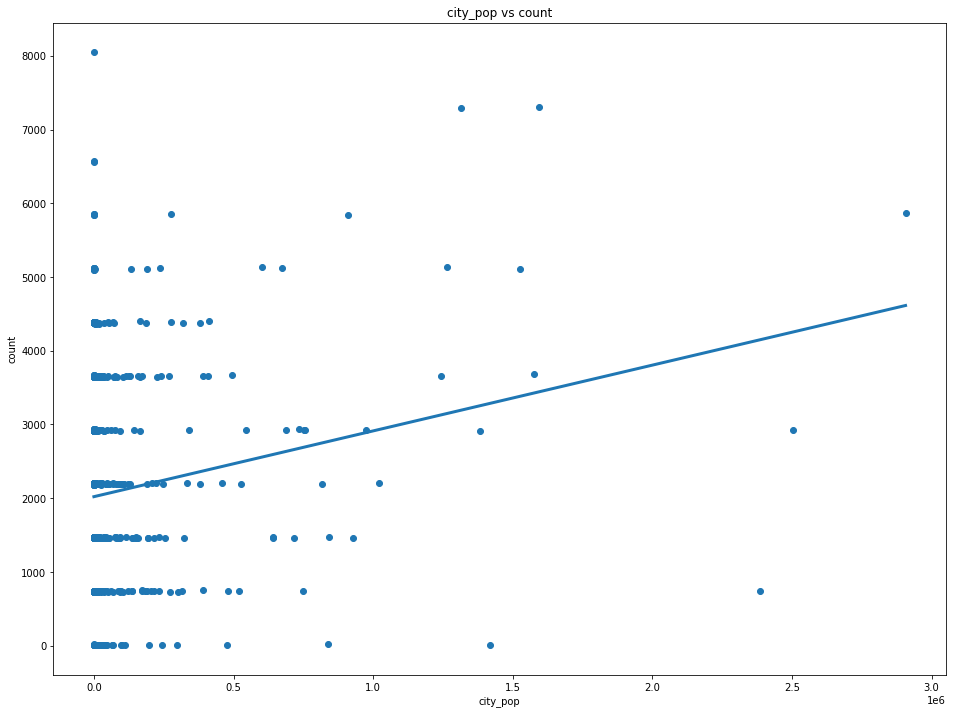

In [38]:
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt

X = txn_counts_by_city_pop[['city_pop']]
y = txn_counts_by_city_pop[['count']]

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(X, y)

# plot it as in the example at http://scikit-learn.org/
plt.figure(figsize=(16, 12))
plt.scatter(X, y)
plt.plot(X, regr.predict(X), linewidth=3)
plt.title('city_pop vs count')
plt.xlabel('city_pop')
plt.ylabel('count')
plt.show()

In [18]:
print(regr.coef_)
print(regr.intercept_)

[[0.00089208]]
[2020.99137073]


<AxesSubplot:ylabel='Count'>

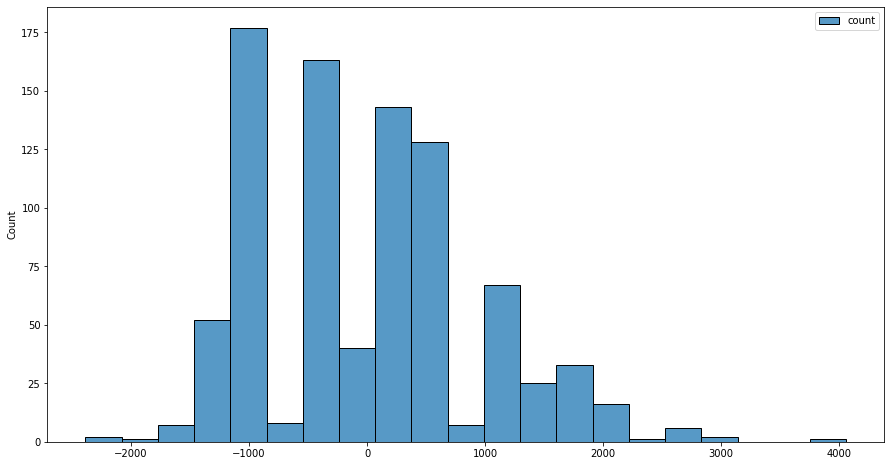

In [38]:
# Plot the average deviations from the predicted values

import seaborn as sns

plt.figure(figsize=(15,8))
sns.histplot(y - regr.predict(X))

In [35]:
# Use statsmodels to get predictive statistics

import statsmodels.api as sm

X = txn_counts_by_city_pop[['city_pop']]
y = txn_counts_by_city_pop[['count']]

X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print(results.pvalues)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     21.42
Date:                Fri, 06 Nov 2020   Prob (F-statistic):           4.23e-06
Time:                        21:33:11   Log-Likelihood:                -7685.2
No. Observations:                 891   AIC:                         1.537e+04
Df Residuals:                     889   BIC:                         1.538e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2020.9914     46.916     43.077      0.0

<AxesSubplot:>

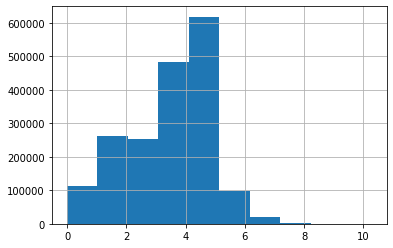

In [46]:
fraud_df['log_amt'].hist()

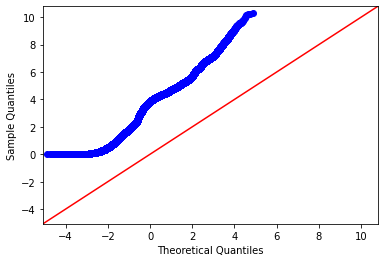

In [48]:
import numpy as np
import statsmodels.api as sm
import pylab

test = fraud_df['log_amt']

sm.qqplot(test, line='45')
pylab.show()

StandardScaler()
[70.06356748]


<ipython-input-65-073c6be4ec1a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['amt']] = scaler.transform(test)
/Users/perkinsc/Documents/Northeastern/EAI6000/eai6000_group5/env/lib/python3.8/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/Users/perkinsc/Documents/Northeastern/EAI6000/eai6000_group5/env/lib/python3.8/site-packages/pandas/core/frame.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

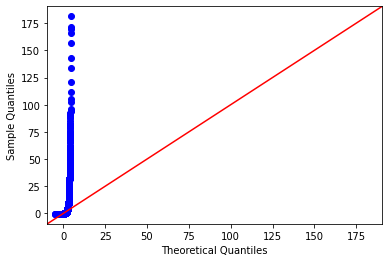

In [65]:
from sklearn.preprocessing import StandardScaler
test = fraud_df[['amt']]
scaler = StandardScaler()
print(scaler.fit(test))
print(scaler.mean_)
# print(scaler.transform(test))

test[['amt']] = scaler.transform(test)

# test['amt'].hist(bins=range(10))

sm.qqplot(test['amt'], line='45')
pylab.show()


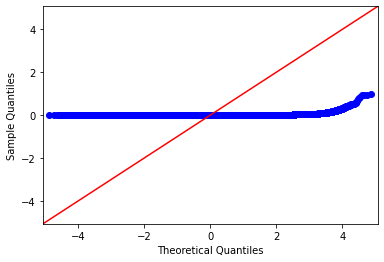

In [70]:
from sklearn import preprocessing

x = fraud_df[['amt']].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_df = pd.DataFrame(x_scaled)

x_df.columns = ['amt']

# print(x_df)

sm.qqplot(x_df['amt'], line='45')
pylab.show()

       amt
7793  1.01
9521  1.01
6548  1.02
3080  1.03
2163  1.03
5130  1.03
9139  1.03
6893  1.03
953   1.03
7530  1.03


Text(0, 0.5, 'is_fraud')

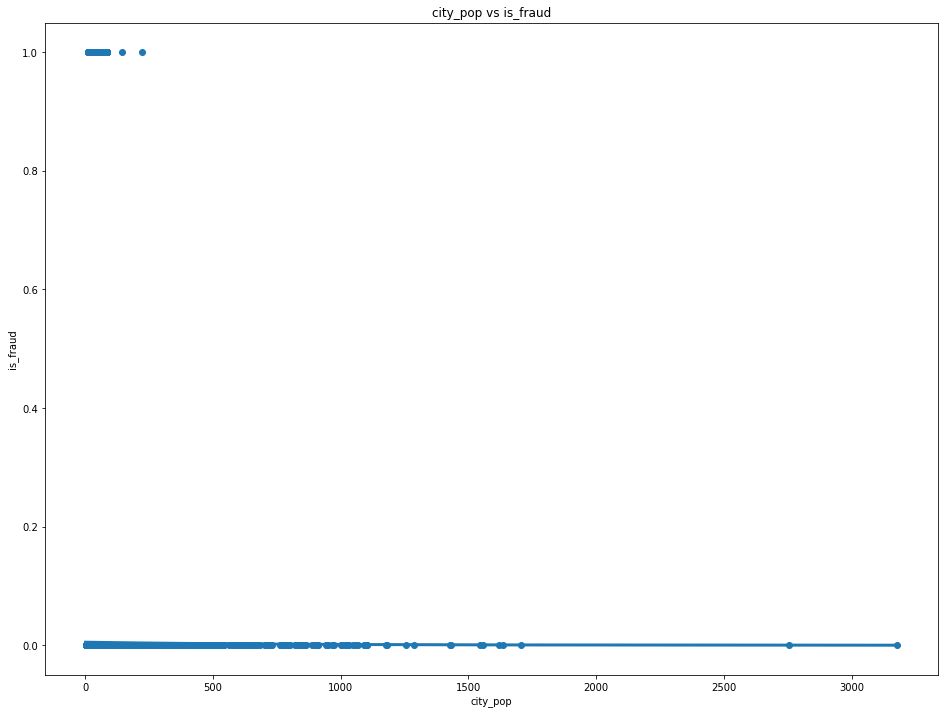

In [15]:
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from sklearn import preprocessing

# qgrid.show_grid(txn_counts_by_city_pop.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})


# ax = txn_counts_by_city_pop.plot(kind='scatter', x='city_pop', y='count', figsize=(16,12), title='age vs amt')

X = fraud_df.head(10000)[['amt']]
y = fraud_df.head(10000)['is_fraud'].ravel()

X = X.sort_values(by=['amt'])
print(X.head(10))

regr = linear_model.LogisticRegression()
regr.fit(X, y)

# plot it as in the example at http://scikit-learn.org/
plt.figure(figsize=(16, 12))
plt.scatter(X, y)
plt.plot(X, regr.predict_proba(X)[:,1], linewidth=3)
plt.title('city_pop vs is_fraud')
plt.xlabel('city_pop')
plt.ylabel('is_fraud')

# import seaborn as sns
# sns.regplot(x='amt', y='is_fraud', data=fraud_df.head(10000), logistic=True)



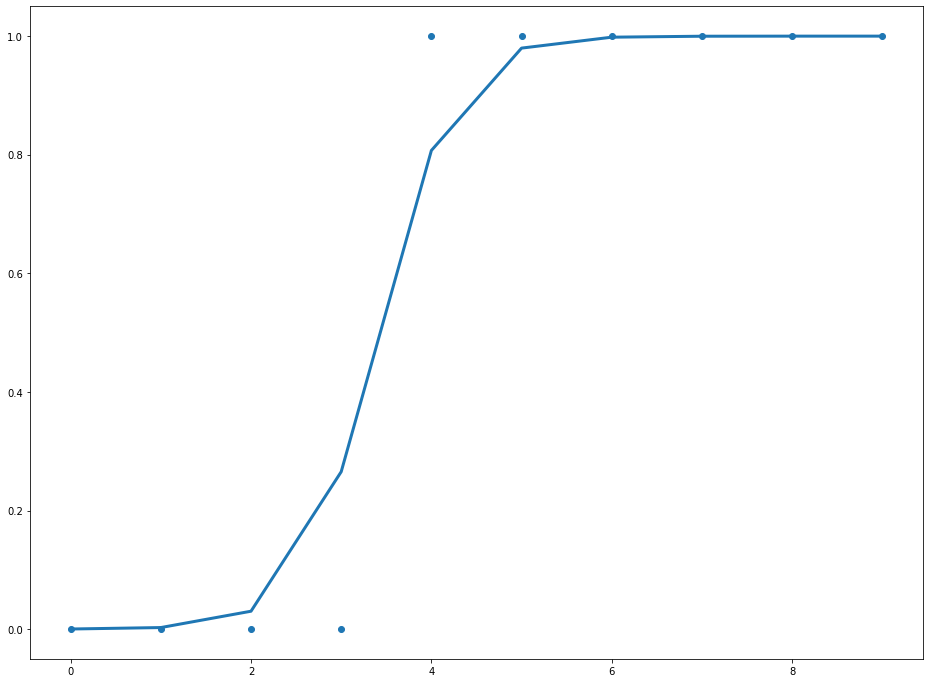

In [39]:
from sklearn import datasets, linear_model

X = np.arange(10).reshape(-1, 1)
y = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

model = linear_model.LogisticRegression(solver='liblinear', random_state=0, C=100.0)

model.fit(X, y)

plt.figure(figsize=(16, 12))
plt.scatter(X, y)
plt.plot(X, model.predict_proba(X)[:, 1], linewidth=3)

In [41]:
from sklearn.metrics import confusion_matrix

# y_true = [2, 0, 2, 2, 0, 1]
# y_pred = [0, 0, 2, 2, 0, 2]
# confusion_matrix(y_true, y_pred)

confusion_matrix(y, model.predict(X))



array([[4, 0],
       [0, 6]])

<ipython-input-29-62bba5ecbd19>:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


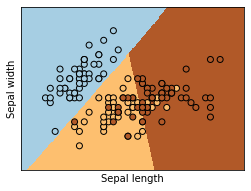

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features.
Y = iris.target

logreg = LogisticRegression(C=1e5)

# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X, Y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

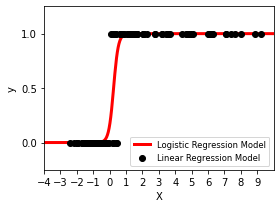

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from scipy.special import expit

# General a toy dataset:s it's just a straight line with some Gaussian noise:
xmin, xmax = -5, 5
n_samples = 100
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0).astype(np.float)
X[X > 0] *= 4
X += .3 * np.random.normal(size=n_samples)

X = X[:, np.newaxis]

# Fit the classifier
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X, y)

# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)

plt.ylabel('y')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

       amt
7793  1.01
9521  1.01
6548  1.02
3080  1.03
2163  1.03
5130  1.03
9139  1.03
6893  1.03
953   1.03
7530  1.03


Text(0, 0.5, 'gender')

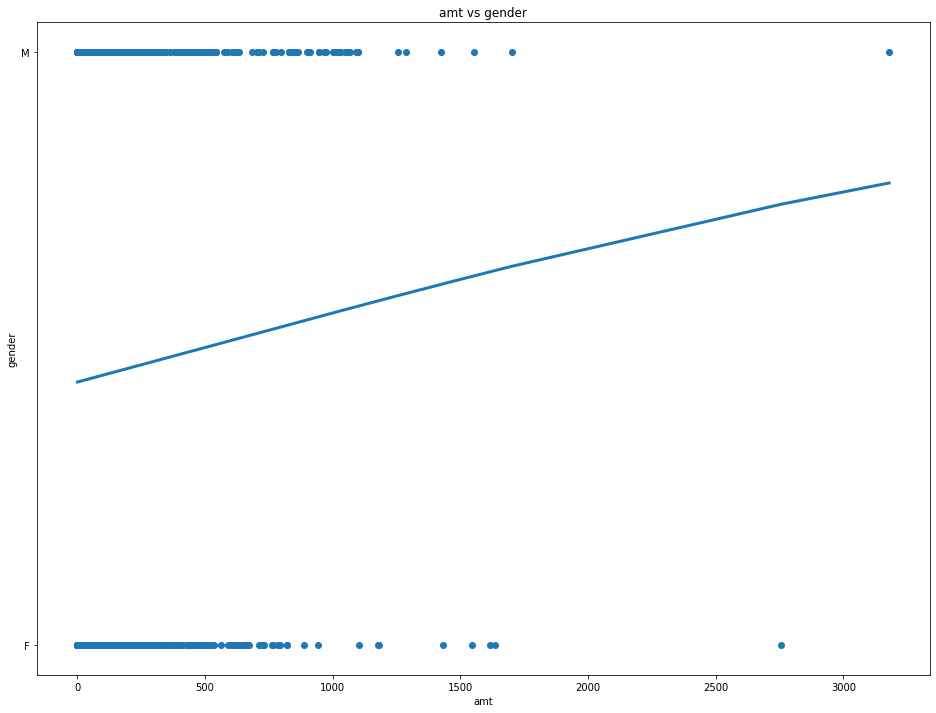

In [31]:
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from sklearn import preprocessing

# qgrid.show_grid(txn_counts_by_city_pop.head(100), grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})


# ax = txn_counts_by_city_pop.plot(kind='scatter', x='city_pop', y='count', figsize=(16,12), title='age vs amt')

X = fraud_df.head(10000)[['amt']]
y = fraud_df.head(10000)['gender'].ravel()

X = X.sort_values(by=['amt'])
# y = np.where(y=='F', 1.0, y) 
# y = np.where(y=='M', 0.0, y) 

print(X.head(10))

regr = linear_model.LogisticRegression()
regr.fit(X, y)

# plot it as in the example at http://scikit-learn.org/
plt.figure(figsize=(16, 12))
plt.scatter(X, y)
plt.plot(X, regr.predict_proba(X)[:,1], linewidth=3)
plt.title('amt vs gender')
plt.xlabel('amt')
plt.ylabel('gender')

# import seaborn as sns
# sns.regplot(x='amt', y='is_fraud', data=fraud_df.head(10000), logistic=True)



In [15]:
fraud_df.groupby(['cc_num', 'first', 'last'])['amt'].agg('sum').nlargest(10)

cc_num            first    last    
6011367958204270  Tammy    Ayers       296436.73
4908846471916297  Lauren   Torres      290478.49
6011438889172900  Allison  Allen       284013.50
36722699017270    Jessica  Perez       280008.05
6011893664860915  Erin     Chavez      278325.97
6011109736646996  Rebecca  Erickson    278139.27
3583635130604947  Crystal  Gamble      278042.99
2712209726293386  Jenna    Brooks      277085.65
4836998673805450  Susan    Hardy       275930.63
372509258176510   Kristen  Hanson      275889.68
Name: amt, dtype: float64

In [18]:
fraud_counts = fraud_df['is_fraud'].value_counts().sort_index().reset_index()
fraud_counts.columns = ['is_fraud','count']

# print(fraud_counts)

no_fraud_count = fraud_counts.loc[fraud_counts['is_fraud'] == 0].iloc[0]['count']
fraud_count = fraud_counts.loc[fraud_counts['is_fraud'] == 1].iloc[0]['count']

percent_with_fraud = "{:.2f}".format(((fraud_count / no_fraud_count) * 100))

print(f"No Fraud Count: {no_fraud_count}")
print(f"Fraud Count: {fraud_count}")
print(f"Fraud Percentage: {percent_with_fraud}%")

   is_fraud    count
0         0  1289169
1         1     7506
No Fraud Count: 1289169
Fraud Count: 7506
Fraud Percentage: 0.58%
